In [58]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [6]:
# !pip install gensim
# !pip install spacy

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')

In [59]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [60]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [72]:
df = pd.read_csv('/Users/u6066091/Desktop/kaggle/output/corona_challenge/biorxiv.csv')
# data = df.text_body.values.tolist()
# we have to do topic modeling per sentence
data = df.title.values.tolist()
# for text in df['title']:
#     sentence = text.split('/n')
#     data.extend(sentence)

In [73]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

In [74]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [75]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# !python -m spacy download en

In [76]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# took forever
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en

nlp = spacy.load('en', disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# # ValueError: [E088] Text of length 1500313 exceeds maximum of 1000000. 
# # The v2.x parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input.
# # This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. 
# # The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.

# print(data_lemmatized[:1])

In [65]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [77]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# data_lemmatized = data_words_bigrams
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View


In [85]:
###### Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [86]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.088*"protein" + 0.039*"vaccine" + 0.026*"induce" + 0.023*"replication" + '
  '0.021*"mouse" + 0.021*"effect" + 0.020*"associate" + 0.018*"strain" + '
  '0.017*"outbreak" + 0.017*"high"'),
 (1,
  '0.073*"viral" + 0.032*"detection" + 0.024*"clinical" + 0.022*"novel" + '
  '0.021*"child" + 0.020*"target" + 0.016*"health" + 0.016*"immune" + '
  '0.016*"tract" + 0.014*"type"'),
 (2,
  '0.069*"cell" + 0.052*"role" + 0.036*"response" + 0.032*"human" + '
  '0.030*"wing" + 0.023*"model" + 0.021*"gene" + 0.021*"antiviral" + '
  '0.021*"sequence" + 0.014*"bat"'),
 (3,
  '0.132*"infection" + 0.066*"disease" + 0.040*"base" + 0.031*"infectious" + '
  '0.022*"system" + 0.017*"infect" + 0.015*"antibody" + 0.015*"control" + '
  '0.015*"factor" + 0.014*"development"'),
 (4,
  '0.059*"use" + 0.040*"host" + 0.031*"receptor" + 0.023*"emerge" + '
  '0.021*"pathogen" + 0.021*"new" + 0.019*"evaluation" + 0.017*"avian" + '
  '0.016*"rapid" + 0.016*"global"'),
 (5,
  '0.080*"respiratory" + 0.067*"tran

In [84]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.122792335941817

Coherence Score:  0.3465460728806035


In [87]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.369344  0.115941       1        1  18.075895
6     -0.180078  0.340227       2        1  15.166305
1     -0.056115 -0.132470       3        1  15.149033
3     -0.037674 -0.091035       4        1  14.589785
0     -0.033826 -0.081538       5        1  13.294223
5     -0.035626 -0.092809       6        1  13.144164
4     -0.026025 -0.058317       7        1  10.580596, topic_info=              Term         Freq        Total Category  logprob  loglift
70           virus  3403.000000  3403.000000  Default  30.0000  30.0000
37       infection  1583.000000  1583.000000  Default  29.0000  29.0000
183        protein   966.000000   966.000000  Default  28.0000  28.0000
39     respiratory   872.000000   872.000000  Default  27.0000  27.0000
3             cell  1023.000000  1023.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
388   intervention    67.053673    67.881622   Topic7  -4.8683   2.2339
125     assessment    59.134022    59.959087   Topic7  -4.9939   2.2323
843           wild    57.932674    58.759007   Topic7  -5.0145   2.2320
327    perspective    52.605145    53.430534   Topic7  -5.1109   2.2306
1770    biological    50.551483    51.376785   Topic7  -5.1508   2.2300

[242 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
365       6  0.997074  activity
81        6  0.996382     acute
363       2  0.993517     adult
372       7  0.992288       age
92        3  0.995768     agent
...     ...       ...       ...
7092      3  0.006367      wing
7092      4  0.008489      wing
7092      5  0.006367      wing
7092      6  0.008489      wing
7092      7  0.006367      wing

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 4, 1, 6, 5])

In [89]:
mallet_path = '/Users/u6066091/Desktop/kaggle/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False)

[(18,
  [('outbreak', 0.05582097058083983),
   ('epidemic', 0.043248679909479504),
   ('impact', 0.03143072667840081),
   ('dynamic', 0.030173497611264772),
   ('spread', 0.02539602715614785),
   ('syndrome', 0.02388735227558461),
   ('pattern', 0.023133014835302994),
   ('pandemic', 0.02263012320844858),
   ('contact', 0.019612773447322103),
   ('management', 0.018606990193613275)]),
 (16,
  [('host', 0.08140422284406004),
   ('antiviral', 0.06792164843551259),
   ('target', 0.06715848384634952),
   ('potential', 0.05113202747392521),
   ('approach', 0.03790384126176546),
   ('interaction', 0.03154413635207327),
   ('identify', 0.03103535995929789),
   ('drug', 0.03001780717374714),
   ('peptide', 0.029254642584584076),
   ('therapeutic', 0.0287458661918087)]),
 (9,
  [('virus', 0.38944723618090454),
   ('diarrhea', 0.053266331658291456),
   ('strain', 0.04773869346733668),
   ('isolate', 0.027889447236180906),
   ('pig', 0.02512562814070352),
   ('variant', 0.021859296482412062),
   

In [90]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3465776287677863


In [92]:
# Topic optimization
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [97]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

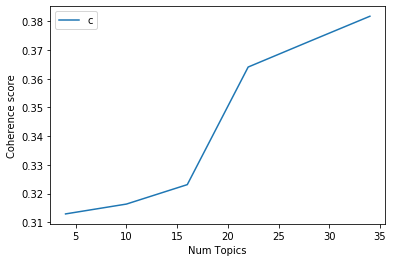

In [99]:
# Show graph
limit=40; start=4; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [103]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.215*"protein" + 0.098*"receptor" + 0.066*"bind" + 0.057*"domain" + '
  '0.042*"structural" + 0.033*"fusion" + 0.031*"epitope" + 0.028*"peptide" + '
  '0.023*"spike" + 0.022*"site"'),
 (20,
  '0.156*"analysis" + 0.113*"sequence" + 0.085*"reveal" + 0.044*"genome" + '
  '0.042*"pattern" + 0.037*"genomic" + 0.020*"diversity" + 0.019*"proteomic" + '
  '0.018*"variation" + 0.015*"cluster"'),
 (29,
  '0.091*"outbreak" + 0.074*"epidemic" + 0.045*"early" + 0.038*"model" + '
  '0.033*"contact" + 0.029*"title" + 0.024*"animal" + 0.024*"time" + '
  '0.021*"measure" + 0.020*"chinese"'),
 (32,
  '0.295*"virus" + 0.097*"infect" + 0.033*"fever" + 0.033*"derive" + '
  '0.032*"protect" + 0.032*"mouse" + 0.028*"hepatitis" + 0.021*"screening" + '
  '0.018*"resistant" + 0.018*"experimental"'),
 (7,
  '0.164*"detection" + 0.064*"method" + 0.050*"rapid" + 0.044*"sample" + '
  '0.037*"feline" + 0.036*"detect" + 0.031*"assay" + 0.031*"comparison" + '
  '0.025*"cat" + 0.018*"diagnostic"'),
 (12,
  '0.

In [104]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,28.0,0.0487,"virus, diarrhea, strain, isolate, pig, variant...",Complete Genome Sequence of Bordetella bronchi...
1,1,0.0,0.0294,"infection, viral, level, increase, reduce, low...",NaN
2,2,1.0,0.0946,"response, immune, induce, mouse, enhance, immu...",Two novel HLA-A*0201 T-cell epitopes in avian ...
3,3,1.0,0.0591,"response, immune, induce, mouse, enhance, immu...",Protective Effects of Long Pentraxin PTX3 on L...
4,4,29.0,0.0671,"outbreak, epidemic, early, model, contact, tit...",Veterinary Science Short Communication Prevale...
5,5,0.0,0.0294,"infection, viral, level, increase, reduce, low...",NaN
6,6,4.0,0.0643,"influenza, bat, virus, avian, coronaviruse, ch...",Detection of Group 1 Coronaviruses in Bats in ...
7,7,0.0,0.0294,"infection, viral, level, increase, reduce, low...",NaN
8,8,6.0,0.0429,"viral, role, pathogen, bacterial, multiple, pa...",Common Commercial Cosmetic Products Induce Art...
9,9,14.0,0.0778,"human, antibody, tissue, bovine, blood, calf, ...",Human Metapneumovirus and Other Respiratory Vi...


In [105]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3457,"infection, viral, level, increase, reduce, low...",impaired production of immune mediators in den...
1,1.0,0.1614,"response, immune, induce, mouse, enhance, immu...",Specific Plasma Autoantibody Reactivity in Mye...
2,2.0,0.2140,"base, model, approach, surveillance, datum, ev...",Steps to a Sustainable Public Health Surveilla...
3,3.0,0.1616,"antiviral, target, activity, potential, drug, ...",HIV-1 Frameshift RNA-Targeted Compounds Incorp...
4,4.0,0.1703,"influenza, bat, virus, avian, coronaviruse, ch...",Antivirals for influenza-like illness? Protoco...


In [118]:
!pip install scispacy


     |████████████████████████████████| 3.0 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 858 kB 27.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 3.0 MB/s eta 0:00:01
  Using cached rsa-3.4.2-py2.py3-none-any.whl (46 kB)
     |████████████████████████████████| 150 kB 2.9 MB/s eta 0:00:01
  Created wheel for scispacy: filename=scispacy-0.2.4-py3-none-any.whl size=35203 sha256=6214d3109a98cf3065ea8012fe93a7fb6ade9aef68f01500f6419b9dde084577
  Stored in directory: /Users/u6066091/Library/Caches/pip/wheels/96/24/54/8c2bf5a6804275431a74bd256821500b3f2911d9ba8470a846
Successfully built scispacy
  Attempting uninstall: botocore
    Found existing installation: botocore 1.15.24
    Uninstalling botocore-1.15.24:
      Successfully uninstalled botocore-1.15.24
  Attempting uninstall: rsa
    Found existing installation: rsa 4.0
    Uninstalling rsa-4.0:
      Successfully uninstalled rsa-4.0
